In [73]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint

%matplotlib inline
plt.style.use('seaborn') # White labels for plots

In [12]:
# Use RELOAD=True mode to import pickles and avoid retraining models 
from joblib import dump, load
model_fpath = 'saved_models/3_'
RELOAD = True

In [13]:
if RELOAD:
    mnist = load(model_fpath+'mnist.joblib')
else:
    mnist = fetch_openml('mnist_784', version=1)
    dump(mnist, model_fpath+'mnist.joblib')

mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [14]:
X, y = mnist['data'], mnist['target']

In [15]:
print(X.shape, y.shape)

(70000, 784) (70000,)


To examine the numbers, we simply have to re-shape them as 28x28 images and plot

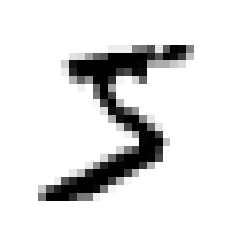

In [16]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

Looks like a 5

In [17]:
y[0]

'5'

The y array is of type string, let's convert it to ints

In [18]:
y = y.astype(np.uint8)

The dataset is already split into a shuffled training and test set. The first 60k images are for training and the last 10k for testing

In [19]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

### Training a Binary Classifier

We'll sart by simplifying the problem and try to identify one digit only, 5. This classifier should have two outputs: 5 and not-5

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Let's start by using a Stochastic Gradient Descent (SGD)

In [21]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
sgd_clf.predict([X[0]])

array([ True])

Yay, it's a 5!

## Performance Measures for classifiers

Evaluating classifiers is trickier than rgressors, we will spend a good portion of this chapter on this topic.

### Measuring using cross validation

In [24]:
from sklearn.model_selection import cross_val_score

if RELOAD:
    cross_val = load(model_fpath+'cross_val.joblib')
else:
    cross_val = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
    dump(mnist, model_fpath+'cross_val.joblib')

cross_val

array([0.87082583, 0.87089354, 0.88628294])

Despite the high accuracy scores obtained, we should not rely on accuracy alone for classifiers. Take a look for example at the classifier below which classify numbers as correct if they're never a 5.

In [26]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X, y=None):
        return np.zeros((len(X), 1), dtype=bool)

The above classifier always predicts zeros. That is, it always says the input vector (X_test) is not equal to its labels (y_train_5)

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy! But this is happening, because only about 10% of dataset contains images of 5s, so if you always guess that an image is not a 5 you'll be right about 90% of the time

Thus accuracy is generally not the preferred measure for classifiers, especially when we're dealing with skewed datasets

### Confusion Matrix

A confusion matrix, will tell us how many times instances of class A were labeled as B by our model. Let's create a set of predictions for our training set

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.3s finished


The cross val predict function, returns predictions made on each test fold. Meaning that each prediction was made by a model that never saw the validation data during test.

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

The first row represents non-5 images (the negative class). 
* 53k of them were correctly identified as non 5s (true negatives).
* 687 were incorrectly identified as non-5s (false negatives).

The second row represents the images of 5s.
* 1,8k of them were incorrectly classified as 5s (false positives)
* 3,5k of them were correctly identified as 5s (true positives)

A perfect classifier would have only true positives and negatives. So its confusion matrix would have non-zero values only on the main diagonal

In [30]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

**Precision** is a measure of the accuracy of the positive predictions

$$ \text{precision} := \frac{TP}{TP + FP}$$

Where TP = number of true positives and FP = number of false positives

**Recall** (*or sensitivity / true positive rate*) is the ratio of positive instances that are correctly detected by the classifier

$$ \text{recall} := \frac{TP}{TP + FN} $$

Where FN = number of false negatives

We can compute these metrics with ScikitLearn

In [31]:
from sklearn.metrics import precision_score, recall_score

sgd_precision = precision_score(y_train_5, y_train_pred)
sgd_recall = recall_score(y_train_5, y_train_pred)
print(f'Precision {sgd_precision}')
print(f'Recall {sgd_recall}')

Precision 0.8370879772350012
Recall 0.6511713705958311


We can combine the two metrics into one by using the $F_1$ score, the **harmonic mean**.
 While a regular mean treats both values equally, the harmonic mean gives much more weight to low values. Thus the classifier will only get a good $F_1$ score if both recall and precision are high

$$ F_1 := \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2\times\frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN+FP}{2}} $$

In [32]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1$ score favors classifiers that have similar precision and recall, but this is not always what you want. Depending on context, one might be more favourable than other (see examples in the book)

### Precision / Recall Trade-off

When making a prediction, classifiers will place an entry in a certain class if it's threshold is greater than a certain value. This means that by increasing or lowering said treshold, we can affect Precision and Recall

In the book example, increasing the threshold increases number of correctly classified 5s, thus increasing precision. However this causes more false negatives to ocurr, which means recall goes down.

Scikit-learn doesn't let us modify the threshold for a model, however it does give us access to the decision function of the model and we can use it against our data to get a score for each entry, and classify them according to some threshold we set.

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_scores, y_some_digit_pred)

[2164.22030239] [ True]


But how do we decide which threshold to use?

We start by using *cross_val_predict* to get scores for the decision function

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

Then we use these scores to compute the *precision_recall_curve* to compute precision and recall for all possible thresholds

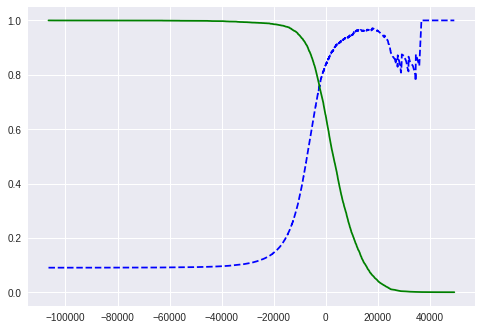

In [41]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

Answer this without looking at the book: why does precision drops off if we increase the threshold, while recall stays the same?

#### Answer: 
Increasing precision might remove true positives while keeping false negatives (see image 3.3 in book)

### The ROC Curve

The *receiver operating curve* (ROC) is another tool used with binary classifiers. We need a few more definitions. First; the *recall* can also be referred to as **true positive rate (TPR)**.

Next we define the **false positive rate (FPR)**, the ratio of negative instances, incorrectly classified as positive.
$$ \text{FPR} := \frac{FN}{TP + FN} $$

The **true negative rate (TNR or *specificity*)** is the ratio of negative instances that are correctly classified as negative
$$ \text{TNR} := \frac{TN}{TN + FP} $$
And we also have $\text{FPR} = 1 - \text{TNR}$

The **ROC** curve plots *sensitivity (recall) vs specificity (tnr)*

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [38]:
def plot_roc_curve(fpr, tpr, label=None, linestyle='-', color='b'):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC curve')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate (Specificity)')

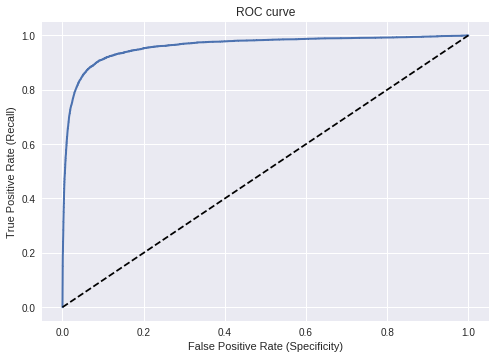

In [42]:
plot_roc_curve(fpr, tpr)

Once again there is a trade off; the higher the recall, the more false positives we get.

The dashed line above represents a purely random classifier. A good classifier tries to stay as far as possible from this line

One way to compare classifiers, is to calculate the *area under the curve (AUC)* of the ROC curve. A perfect classifier would have AUC=1.0 while a random classifier has AUC=0.5.

In [43]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

##### Note:
Interesting comparison between Precision/Recall and ROC curves on book!

Let's create a RandomForestClassifier to compare against the SGD

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method='predict_proba')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The output of the forest model is an array containing a row per instance and a column per class. i.e. probabilities of pertaining to each class

In [45]:
y_probas_forest

array([[0.1, 0.9],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ]])

In [46]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

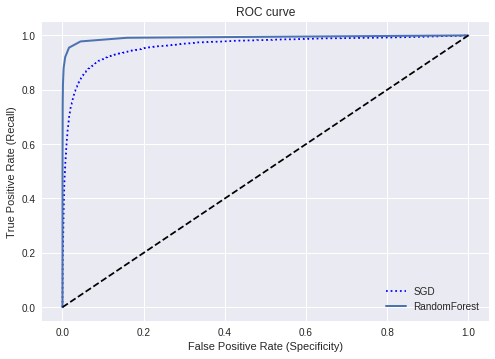

In [47]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='RandomForest')
plt.legend(loc='lower right')
plt.show()

And for the AUC

In [48]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

#### Exercise: Find the recall, and precision scores

In [49]:
forest_preds = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [50]:
forest_precision = precision_score(y_train_5, forest_preds)
forest_recall  = recall_score(y_train_5, forest_preds)
print(f'Precision {forest_precision}')
print(f'Recall {forest_recall}')

Precision 0.986046511627907
Recall 0.8212506917542889


### Multiclass Classification
Let's now predict more than just 5s!

Some algorithms are capable of handing multiple classes natively. E.G. SGD Classifier, RandomForestClassifiers, Naive Bayes.

Others, are strictly binary classifiers (Logistic Regression, Support Vectore Machine classifiers).

However, there are multiple strategies we can take to perform *multinomial* classification

One way is to create a system to train a binary classifier for each pair of digits (a 0-detector, 1-detector, 2-detector and so on). When classifyfing an image, we run the image through all the classifiers and pick the one with the highest score. This approach is called **one vs the rest (OvR)** (or one-vs-all ovr)

Another approach is to train a binary classifier for each pair of digits; one to distinguish 0s from 1s, another to distinguish 0s from 2s and so on. To classify an image, you run each of the classifiers and pick which class wins most duels.

In general if there are N classes, this approach needs $N\times(N-1)/2$ classifiers. This can be efficient for algorithms which scale poorly with the data (e.g. SVCs) as it is easier to train many classifiers on small datasets vs few classifiers on large datasets.

For most classification algorightms, OvR is the preferred method

**Note:** Scikit-Learn detects when you try to use a binary classification algorithm for multinomial classification and automatically runs OvR or OvO depending on the algorithm

In [52]:
from sklearn.svm import SVC

# sklearn runs OvO on the background
if RELOAD:
    svc_clf = load(model_fpath+'svc_clf.joblib')
else:
    svc_clf = SVC()
    svc_clf.fit(X_train, y_train)
    dump(svc_clf, model_fpath+'svc_clf.joblib') 
    
svc_clf.predict([some_digit])

array([5], dtype=uint8)

The rest of this section explains how we can implement an OvO or OvR classifier by simply passing whatever algorithm (SVR, RandomForest, SGD) to the constructor of the OvO/OvR classes

It also trains an SGD on the full dataset to demonstrate that it is a multinomial classifier. This model gets 84% accuracy initially and by scaling the inputs with a standard scaler the accuracy grows to 89%

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

if RELOAD:
    sgd_clf = load(model_fpath+'sgd_clf.joblib')
    y_train_pred = load(model_fpath+'sgd_y_pred.joblib')
else:
    sgd_clf.fit(X_train, y_train)
    dump(sgd_clf, model_fpath+'sgd_clf.joblib') 
    y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
    dump(y_train_pred, model_fpath+'sgd_y_pred.joblib') 

In [54]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [55]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [67]:
if RELOAD:
    sgd_scaled_cross_val = load(model_fpath+'sgd_scaled_cross_val.joblib')
else:
    sgd_scaled_cross_val = cross_val_score(sgd_clf, X_train_scaled, y_train, 
                                           cv=3, scoring='accuracy')
    dump(sgd_clf, model_fpath+'sgd_scaled_cross_val.joblib')
sgd_scaled_cross_val

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### Error Analysis

Assuming the SGD classifier found above is a promising model, let's analyse the types of errors it makes and try to improve it. We'll start by looking at it's confusion matrix

In [68]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

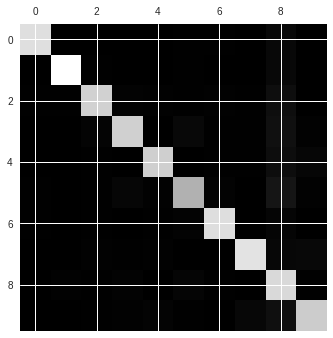

In [69]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The 5s look slightly darker than the other digits, which could mean that there aren't as many images of 5s as for other numbers or that the classifier does not perform as well on 5s as on other digits

Let's start by analysing the errors first. We'll start by normalising the values in the confusion matrix by dividing each entry by the number of images in the correspoding class. 

If we looked at the the absolute number of errors, classis which have lots of images could look unfairly bad

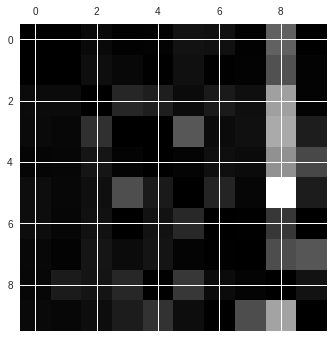

In [70]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) # fill diagonal with zeroes to keep only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In the above, rows are actual classes and columns are our predictions. It is clear from the matrix that the model falsely misclassifies many digits as 8s. However the row for 8s is quite good so it generally classifies 8s well.

In addition, 3s and 5s get confused by the model quite often

Let's look at individual errors the model is making by looking at the 3s and 5s in the dataset

In [74]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

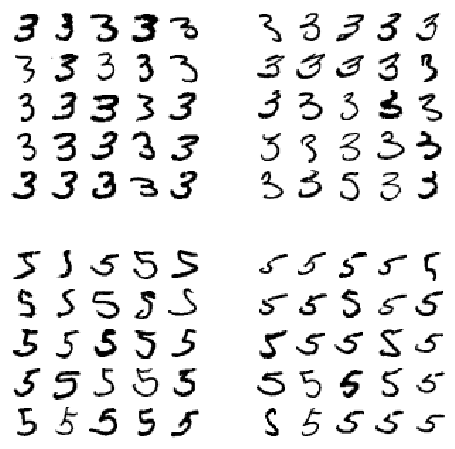

In [76]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

The two 5x5 blocks on the left show images classified as 5s and the ones on the right were classified as 3s. Bottom left and top right are correct classifications.

It is easy to see the model is misclassifying some very obvious images, but this is happening because the SGD is a linear classifier. It assigns weights to each pixel and when it sees a new images, it sums the weighted pixel intensities to generate a classification. Because 5s and 3s differ by only a few pixels, they get easily confused.

One way to improve this classifier would be to preprocess the images and ensure that they are well-centered, thus reducing the effect of shifting and rotation.

Another approach would be to add create various rotations and shifts of the images and pass them while training the model.

### Multilabel classification

Up til now, our models are only classifing each instance to a single class. What if we were building an image recognition system? When it sees an image with multiple people we would like it to output a name for each of them instead of just one. Such as system that outputs multiple binary tags us called a *multilabel classification system*.

A simple example to classify numbers that are large and odd

In [80]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd] # two columns one for large one for odds
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [82]:
if RELOAD:
    knn_clf = load(model_fpath + 'knn_clf.joblib')
else:
    knn_clf = KNeighborsClassifier() # KNN supports multilabel
    knn_clf.fit(X_train, y_multilabel)
    dump(knn_clf, model_fpath + 'knn_clf.joblib')
    
knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Testing it for our sample digit 5

In [84]:
knn_clf.predict([some_digit])

array([[False,  True]])

There are multiple approaches to evaluating multilabel classifiers. One approach is to measure $F_1$ score for each individual label and average all scores. We'll use this approach to measure accuracy for the KNN above

In [132]:
if RELOAD:
    y_train_knn_pred = load(model_fpath + 'knn_cross_val_pred.joblib')
else:
    y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, verbose=2)
    dump(y_train_knn_pred, model_fpath + 'knn_cross_val_pred.joblib')

f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 63.3min finished


0.976410265560605

In [133]:
precision_score(y_multilabel, y_train_knn_pred, average='macro')

0.9744001577165913

### Multioutput classification

This is a generalisaion of multilabel classification, where each label can be multiclass (i.e. can have more than two possible values)

For our MNIST dataset, let's build a system that removes noise from images, taking a noisy digit image as input and output a clean digit image as an array of digit intensities.

The output is multilabel (one label per pixel) and each label can have multiple values (pixel intensities from 0 to 255)

In [139]:
# Create training ant test set by adding noise to MNIST data
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [153]:
if RELOAD:
    knn_clean_clf = load(model_fpath + 'knn_clean_clf.joblib')
else:
    knn_clean_clf = knn_clf.fit(X_train_mod, y_train_mod)
    dump(knn_clean_clf, model_fpath + 'knn_clean_clf.joblib')

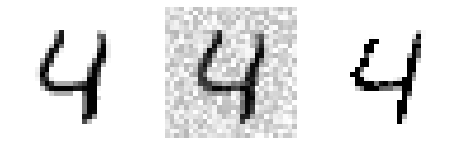

In [158]:
some_index = 4
original = [X_test[some_index]]
noisy_digit = [X_test_mod[some_index]]
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plt.subplot(131); plot_digits(original) # Original Image
plt.subplot(132); plot_digits(noisy_digit) # Noisy Image
plt.subplot(133); plot_digits(clean_digit) # Cleaned up version
plt.show()